Número de muestras leídas: 626
   Tiempo (s)   T1 (C)   T2 (C)   PWM_Heater1   PWM_Heater2
0        0.01    24.93    23.95             0             0
1        1.04    24.93    24.44             0             0
2        2.04    24.93    24.93             0             0
3        3.04    24.93    23.95             0             0
4        4.04    24.93    23.46             0             0
Se detectó un escalón en PWM en el instante t = 10.05 s


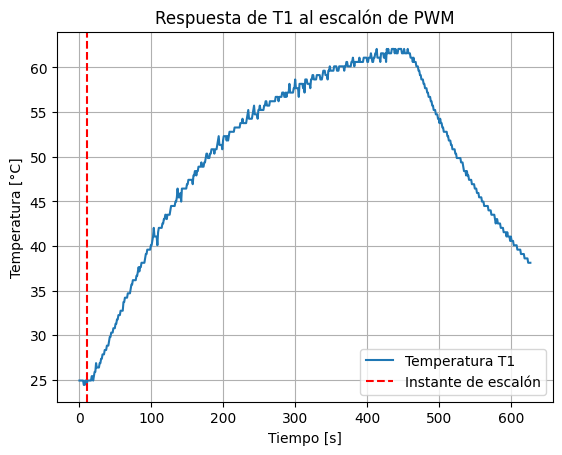

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Leer el archivo de texto
#    Si tu archivo tiene encabezados en la primera fila y está separado por comas:
df = pd.read_csv('Datos.txt')

# 2. Extraer las columnas relevantes
#    Ajusta los nombres de columnas de acuerdo con tu archivo:
tiempo = df['Tiempo (s)'].values
T1 = df[' T1 (C)'].values
pwm = df[' PWM_Heater1'].values

# (Opcional) Verificar rápidamente cuántas filas y columnas se leyeron
print("Número de muestras leídas:", len(df))
print(df.head())

indices_escalon = np.where((pwm[:-1] == 0) & (pwm[1:] > 0))[0]

if len(indices_escalon) == 0:
    print("No se encontró un escalón en PWM_Heater1")
else:
    idx_escalon = indices_escalon[0]  # Tomar el primer cambio
    t_escalon = tiempo[idx_escalon+1]
    print(f"Se detectó un escalón en PWM en el instante t = {t_escalon} s")

    # A partir de este índice, podemos tomar la porción de datos posterior al escalón
    tiempo_escalon = tiempo[idx_escalon:]
    T1_escalon = T1[idx_escalon:]
    pwm_escalon = pwm[idx_escalon:]
plt.figure()
plt.plot(tiempo, T1, label='Temperatura T1')
plt.axvline(t_escalon, linestyle='--', color='r', label='Instante de escalón')
plt.xlabel('Tiempo [s]')
plt.ylabel('Temperatura [°C]')
plt.title('Respuesta de T1 al escalón de PWM')
plt.grid(True)
plt.legend()
plt.show()


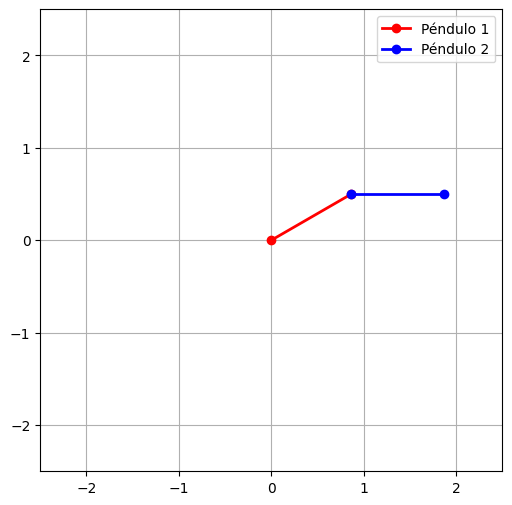

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Parámetros del sistema
m1, m2 = 1.0, 1.5       # Masas
L1, L2 = 1.0, 1.2       # Longitudes de las varillas
g = 9.81                # Gravedad
h = 0.01                # Tamaño del paso temporal
t = 100                 # Tiempo total de simulación


# Condiciones iniciales: [theta1, omega1, theta2, omega2]
y0 = [np.radians(120), 0.0, np.radians(90), 0.0]

# Derivadas del péndulo doble
def pendulum_derivatives(y, m1, m2, L1, L2, g):
    theta1, omega1, theta2, omega2 = y
    delta = theta2 - theta1
    den1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta)**2
    den2 = (L2 / L1) * den1

    dtheta1_dt = omega1
    dtheta2_dt = omega2

    domega1_dt = ((m2 * L1 * omega1**2 * np.sin(delta) * np.cos(delta) +
                   m2 * g * np.sin(theta2) * np.cos(delta) +
                   m2 * L2 * omega2**2 * np.sin(delta) -
                   (m1 + m2) * g * np.sin(theta1)) / den1)

    domega2_dt = ((-m2 * L2 * omega2**2 * np.sin(delta) * np.cos(delta) +
                   (m1 + m2) * g * np.sin(theta1) * np.cos(delta) -
                   (m1 + m2) * L1 * omega1**2 * np.sin(delta) -
                   (m1 + m2) * g * np.sin(theta2)) / den2)

    return np.array([dtheta1_dt, domega1_dt, dtheta2_dt, domega2_dt])


# Método de Euler
def euler_method(y0, h, t, f, m1, m2, L1, L2, g):
    y = np.array(y0)
    results = [y]
    for i in range(0, t, 1):
        y = y + h * f(y, m1, m2, L1, L2, g)
        results.append(y)
    return np.array(results)


# Método de Runge-Kutta de 4to Orden (RK4)
def rk4_method(y0, h, t, f, m1, m2, L1, L2, g):
    y = np.array(y0)
    results = [y]
    for i in range(0, t, 1):
        k1 = f(y, m1, m2, L1, L2, g)
        k2 = f(y + 0.5 * h * k1, m1, m2, L1, L2, g)
        k3 = f(y + 0.5 * h * k2, m1, m2, L1, L2, g)
        k4 = f(y + h * k3, m1, m2, L1, L2, g)
        y = y + (h / 6) * (k1 + 2*k2 + 2*k3 + k4)
        results.append(y)
    return np.array(results)

# Función para calcular las posiciones
def calculate_positions(results, L1, L2):
    theta1 = results[:, 0]
    theta2 = results[:, 2]
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    return x1, y1, x2, y2

# Función para animar el péndulo
def animate_pendulum(results, L1, L2, interval=50):
    x1, y1, x2, y2 = calculate_positions(results, L1, L2)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-L1 - L2 - 0.5, L1 + L2 + 0.5)
    ax.set_ylim(-L1 - L2 - 0.5, L1 + L2 + 0.5)
    ax.set_aspect('equal', adjustable='box')
    ax.grid()
    line1, = ax.plot([], [], 'o-', lw=2, color='red', label='Péndulo 1')
    line2, = ax.plot([], [], 'o-', lw=2, color='blue', label='Péndulo 2')
    ax.legend()

    def update(frame):
        this_x1, this_y1 = x1[frame], y1[frame]
        this_x2, this_y2 = x2[frame], y2[frame]
        line1.set_data([0, this_x1], [0, this_y1])
        line2.set_data([this_x1, this_x2], [this_y1, this_y2])
        return line1, line2

    ani = FuncAnimation(fig, update, frames=len(euler_method(y0=y0, h=h, t=t, f=pendulum_derivatives, m1=m1, m2=m2, L1=L1, L2=L2, g=g)), interval=interval, blit=True)
    plt.show()

# Ejemplo de uso con datos ficticios
# Resultados simulados: theta1, omega1, theta2, omega2
results = np.array([
    [0.5, 0, 0.3, 0],
    [0.49, -0.1, 0.29, -0.1],
    [0.48, -0.2, 0.28, -0.2],
    # Agrega más datos simulados aquí...
])

L1, L2 = 1.0, 1.0  # Longitudes de las varillas
animate_pendulum(euler_method(y0, h, t, pendulum_derivatives, L1=L1, L2=L2, m1=m1, m2=m2, g=g), L1, L2, interval=50)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

def simulate_pendulum(results, L1, L2, filename="pendulum.gif"):
    frames = []
    for y in results:
        theta1, theta2 = y[0], y[2]
        x1, y1 = L1 * np.sin(theta1), -L1 * np.cos(theta1)
        x2, y2 = x1 + L2 * np.sin(theta2), y1 - L2 * np.cos(theta2)

        plt.figure(figsize=(5, 5))
        plt.plot([0, x1], [0, y1], 'r-', label='Varilla 1')  # Varilla 1
        plt.plot([x1, x2], [y1, y2], 'b-', label='Varilla 2')  # Varilla 2
        plt.plot(x1, y1, 'ro', markersize=8)  # Masa 1
        plt.plot(x2, y2, 'bo', markersize=8)  # Masa 2
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.axis('equal')
        plt.grid()
        plt.savefig('frame.png')
        frames.append(imageio.imread('frame.png'))
        plt.close()

    imageio.mimsave(filename, frames, duration=0.05)
    print(f"Simulación guardada como {filename}")
L1=1.0
L2=1.0
results=np.array([
 [ 1.11406723, -4.29140117,  1.37427195, -0.50602217],
[ 1.07115322, -4.30121477,  1.36921173, -0.61777978],
[ 1.02814107, -4.29903415,  1.36303393, -0.74488589],
[ 0.98515073, -4.28586346,  1.35558507, -0.88586319],
[ 0.94229209, -4.26269821,  1.34672644, -1.03913742],
[ 0.89966511, -4.23043267,  1.33633506, -1.20314677],
[ 0.85736078, -4.18980045,  1.32430359, -1.37641705],
[ 0.81546278, -4.14134528,  1.31053942, -1.55760503],
[ 0.77404933, -4.08541571,  1.29496337, -1.74551638],
[ 0.73319517, -4.02217609,  1.27750821, -1.93910659],
])

simulate_pendulum(results, L1, L2, filename="pendulum.gif")

<ipython-input-3-93951694757d>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread('frame.png'))


Simulación guardada como pendulum.gif


Número de muestras leídas: 1405
   Tiempo (s)   T1 (C)   T2 (C)   PWM_Heater1   PWM_Heater2
0        0.01    28.35    28.84           0.0           0.0
1        1.04    28.35    28.84           0.0           0.0
2        2.04    28.35    28.84           0.0           0.0
3        3.04    28.35    28.84           0.0           0.0
4        4.04    27.86    28.35           0.0           0.0


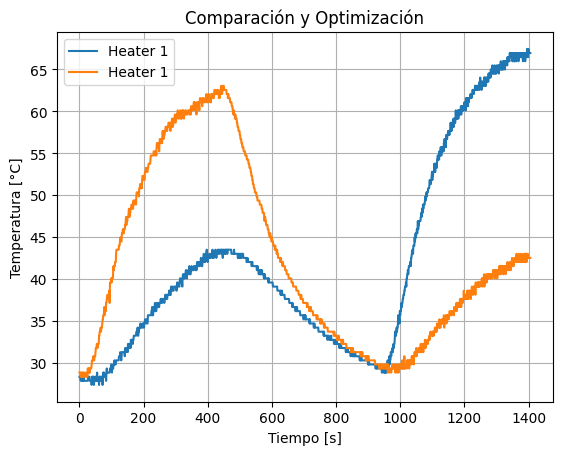

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import minimize

# 1. Leer el archivo de texto
#    Si tu archivo tiene encabezados en la primera fila y está separado por comas:
df = pd.read_csv('Exp1.txt')

# 2. Extraer las columnas relevantes
#    Ajusta los nombres de columnas de acuerdo con tu archivo:
tiempo = df['Tiempo (s)'].values
T1 = df[' T1 (C)'].values
T2 = df[' T2 (C)'].values
pwm = df[' PWM_Heater1'].values

# (Opcional) Verificar rápidamente cuántas filas y columnas se leyeron
print("Número de muestras leídas:", len(df))
print(df.head())

plt.figure()
plt.plot(tiempo, T1, label='Heater 1')
plt.plot(tiempo, T2, label='Heater 1')
plt.xlabel('Tiempo [s]')
plt.ylabel('Temperatura [°C]')
plt.title('Comparación y Optimización')
plt.grid(True)
plt.legend()
plt.show()
